In [1]:
import mysql.connector

import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

# Link MySQL and Python
We want to connect MySQL and Python to read the database in Python directly. Using mysql connector seems appropriate here. Let's write a class that will load the database

In [2]:
class MysqlIO:
    def __init__(self, database='test'):
            connection = mysql.connector.connect(host='127.0.0.1', 
                                                 port='3306',
                                                 database=database,
                                                 user='root',
                                                 password='ForSQL!1',
                                                 use_pure=True
                                                 )
            db_info = connection.get_server_info()
            self.connection = connection
            print(f"Retrieval of database {database} Successful")
            
    def execute(self, query, header=False):
        """Execute SQL commands and return retrieved queries."""
        cursor = self.connection.cursor(buffered=True)
        cursor.execute(query)
        try:
            record = cursor.fetchall()
            if header:
                header = [i[0] for i in cursor.description]
                return {'header': header, 'record': record}
            else:    
                return record
        except:
            pass
        
    def to_df(self, query):
        """Return the retrieved SQL queries into pandas dataframe"""
        res = self.execute(query, header=True)
        df = pd.DataFrame(res['record'])
        df.columns = res['header']
        return df

In [3]:
db = MysqlIO('bank_1999')

Retrieval of database bank_1999 Successful


# Data Exploration

With so many tables, it can be overwhelming to know what to look for. But let's look at them one by one and see what comes up as interesting

### Loan and Account Table
Since the loan and account tables are directly related, we can look at these first

In [4]:
query = """
    select 
    loan_t.date as loan_date, account_t.date as account_date, 
    loan_id, account_id, amount, duration, payments, status, district_id, frequency
    from loan_t 
    join account_t 
    using(account_id);
    """
loan_account_df = db.to_df(query)
display(loan_account_df.head())

,loan_date,account_date,loan_id,account_id,amount,duration,payments,status,district_id,frequency
0,1993-11-22,1993-01-13,6077,5270,79608,24,3317.00,A,44,POPLATEK MESICNE
1,1993-09-15,1993-01-14,7284,11265,52788,12,4399.00,A,15,POPLATEK MESICNE
2,1993-11-10,1993-01-17,7121,10364,21924,36,609.00,A,55,POPLATEK MESICNE
3,1994-09-28,1993-01-19,5754,3834,23052,12,1921.00,A,54,POPLATEK MESICNE
4,1994-09-19,1993-01-24,6895,9307,41904,12,3492.00,A,68,POPLATEK MESICNE


In the column 'status', A and C are still in good standing, and B and D have likley defaulted. Let's make a new column to show this.

I also want to change the frequency column, to values that are easier to understand. 

And lastly, It would be good to know the time between the date the account was created and date the loan was created.

In [5]:
loan_account_df['defaulted'] = np.where(loan_account_df['status'].isin(['A', 'C']), 'no', 'yes')

# Replace Frequency Values
loan_account_df.replace({'POPLATEK MESICNE': 'monthly', 'POPLATEK TYDNE': 'weekly', 'POPLATEK PO OBRATU': 'instant'}, 
                        inplace=True)


# Date conversion
for col in ['loan_date', 'account_date']:
    loan_account_df[col] = pd.to_datetime(loan_account_df[col]) 

loan_account_df['time_elapsed'] = (loan_account_df['loan_date'] - loan_account_df['account_date']).dt.days

display(loan_account_df.sample(10))

,loan_date,account_date,loan_id,account_id,amount,duration,payments,status,district_id,frequency,defaulted,time_elapsed
551,1998-03-11,1996-12-22,5665,3390,40632,12,3386.00,C,12,weekly,no,444
119,1994-09-29,1993-10-08,6738,8566,230220,36,6395.00,B,74,monthly,yes,356
319,1997-08-12,1995-11-28,6677,8169,97980,60,1633.00,C,29,monthly,no,623
188,1995-08-05,1994-08-27,5922,4580,20220,12,1685.00,A,9,monthly,no,343
140,1994-06-06,1993-11-26,6210,5927,87216,48,1817.00,B,15,monthly,yes,192
279,1996-11-15,1995-07-29,6006,4948,359760,60,5996.00,C,43,monthly,no,475
276,1995-11-28,1995-07-22,5805,4081,137904,24,5746.00,B,11,monthly,yes,129
3,1994-09-28,1993-01-19,5754,3834,23052,12,1921.00,A,54,monthly,no,617
312,1996-08-02,1995-11-09,7013,9928,89340,60,1489.00,C,60,monthly,no,267
416,1996-12-21,1996-05-21,6805,8972,45024,48,938.00,C,70,monthly,no,214


no     606
yes     76
Name: defaulted, dtype: int64
amount


<Figure size 504x360 with 0 Axes>

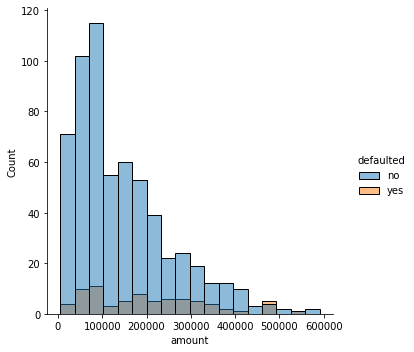

duration


<Figure size 504x360 with 0 Axes>

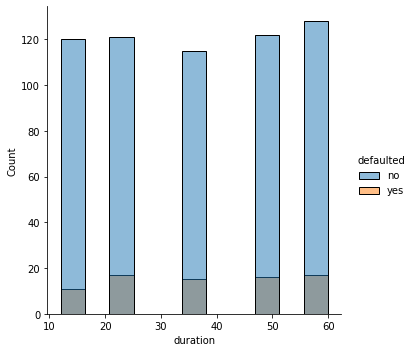

payments


<Figure size 504x360 with 0 Axes>

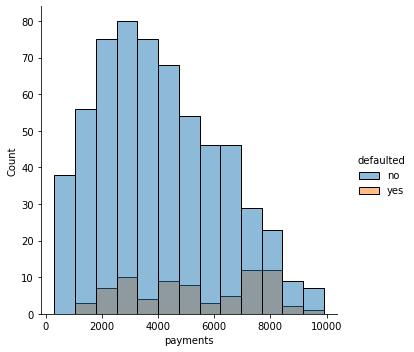

frequency


<Figure size 504x360 with 0 Axes>

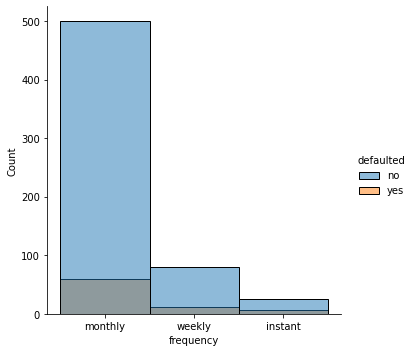

district_id


<Figure size 504x360 with 0 Axes>

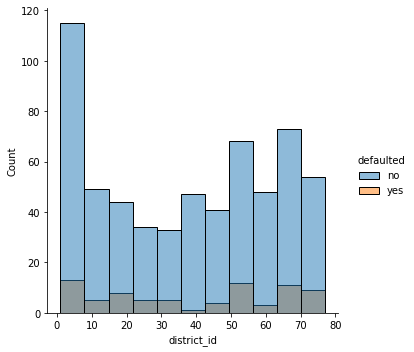

time_elapsed


<Figure size 504x360 with 0 Axes>

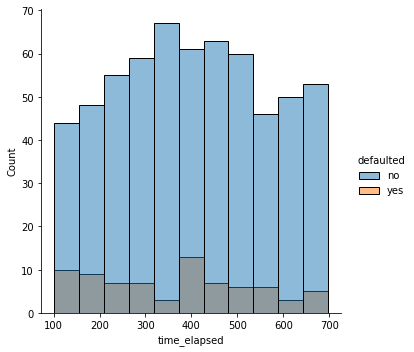

account_date


<Figure size 504x360 with 0 Axes>

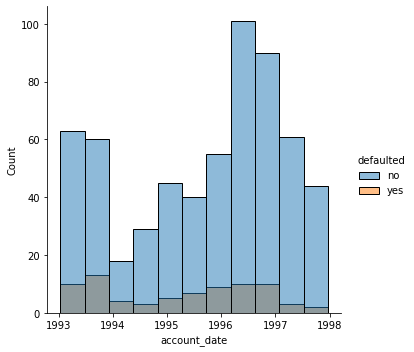

loan_date


<Figure size 504x360 with 0 Axes>

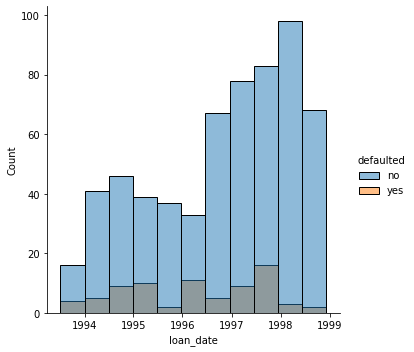

In [6]:
print(loan_account_df['defaulted'].value_counts())

for x in ['amount', 'duration', 'payments', 'frequency', 'district_id', 'time_elapsed', 'account_date', 'loan_date']:
    print(x)
    graph.figure(figsize=(7,5))
    sns.displot(data=loan_account_df, x =x, hue='defaulted')
    graph.show()

'amount', 'duration', 'payments', 'frequency', 'time_elapsed' from loan and account table looks like good predictors

### Loan, account, order

In [7]:
loan_df = db.to_df("select * from loan_t")
loan_df['defaulted'] = np.where(loan_df['status'].isin(['A', 'C']), 'no', 'yes')

display(loan_df.head())

,loan_id,account_id,date,amount,duration,payments,status,defaulted
0,5314,1787,1993-07-05,96396,12,8033.00,B,yes
1,5316,1801,1993-07-11,165960,36,4610.00,A,no
2,6863,9188,1993-07-28,127080,60,2118.00,A,no
3,5325,1843,1993-08-03,105804,36,2939.00,A,no
4,7240,11013,1993-09-06,274740,60,4579.00,A,no


In [8]:
query = """
    select amount as order_amount, account_id
    from perm_order_t
    where account_id in (select account_id from loan_t);
    """
account_order_df = db.to_df(query)
account_order_df['order_amount'] = account_order_df['order_amount'].astype(float)

account_order_df = account_order_df.groupby('account_id').mean().reset_index()
account_order_df.rename(columns = {'order_amount': 'avg_order_amount'}, inplace=True)

display(account_order_df.head())

,account_id,avg_order_amount
0,2,5319.350
1,19,2523.200
2,25,2653.550
3,37,2576.375
4,38,2416.700


In [9]:
print(len(loan_df), len(account_order_df))

682 682


In [10]:
loan_order_account_df = pd.merge(loan_df, account_order_df, on='account_id')
display(loan_order_account_df.head())

,loan_id,account_id,date,amount,duration,payments,status,defaulted,avg_order_amount
0,5314,1787,1993-07-05,96396,12,8033.00,B,yes,8033.200000
1,5316,1801,1993-07-11,165960,36,4610.00,A,no,3288.000000
2,6863,9188,1993-07-28,127080,60,2118.00,A,no,2647.825000
3,5325,1843,1993-08-03,105804,36,2939.00,A,no,4966.350000
4,7240,11013,1993-09-06,274740,60,4579.00,A,no,4944.666667


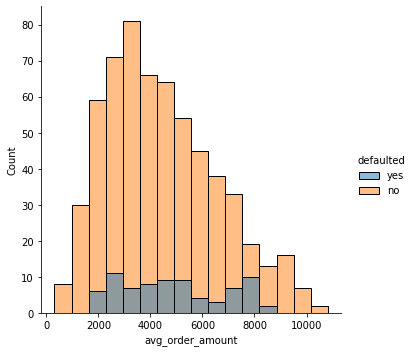

In [11]:
sns.displot(data=loan_order_account_df, x = 'avg_order_amount', hue='defaulted')
graph.show()

The average order amount per client seems to be a good predictor to include here

### Loan, account, transaction
Here I also want to see how many transactions a client have performed, this might be an indication of how they will perform on their loan

In [12]:
query = """
    select amount as trans_amount, balance as bal_amount, account_id
    from transaction_t
    where account_id in (select account_id from loan_t);
    """
transaction_df = db.to_df(query)

display(transaction_df.head())

,trans_amount,bal_amount,account_id
0,800,800,5270
1,44749,45549,5270
2,1000,1000,11265
3,1100,1100,10364
4,700,700,3834


In [13]:
transaction_df['number_trans'] = transaction_df.groupby('account_id')['account_id'].transform('count')
transaction_df = transaction_df.groupby('account_id').mean().reset_index()
transaction_df.rename(columns = {'trans_amount': 'avg_trans_amount'})
transaction_df

,account_id,trans_amount,bal_amount,number_trans
0,2,6593.125523,36540.780335,478.0
1,19,5199.775578,16253.069307,303.0
2,25,10797.649635,56279.237226,274.0
3,37,7293.530769,37547.484615,130.0
4,38,4399.630769,34462.384615,130.0
...,...,...,...,...
677,11327,7465.120000,56689.613333,75.0
678,11328,9087.869863,46942.369863,146.0
679,11349,13017.690789,48769.490132,304.0
680,11359,7799.198413,36105.851852,378.0


In [14]:
loan_trans_df = pd.merge(loan_df, transaction_df, on='account_id')
display(loan_trans_df.head())

,loan_id,account_id,date,amount,duration,payments,status,defaulted,trans_amount,bal_amount,number_trans
0,5314,1787,1993-07-05,96396,12,8033.00,B,yes,10195.764268,44264.573201,403.0
1,5316,1801,1993-07-11,165960,36,4610.00,A,no,7506.873618,43499.842022,633.0
2,6863,9188,1993-07-28,127080,60,2118.00,A,no,3242.935537,29452.327273,605.0
3,5325,1843,1993-08-03,105804,36,2939.00,A,no,5983.716450,35669.385281,462.0
4,7240,11013,1993-09-06,274740,60,4579.00,A,no,11166.880911,56912.579685,571.0


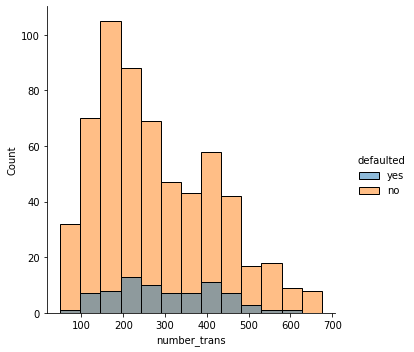

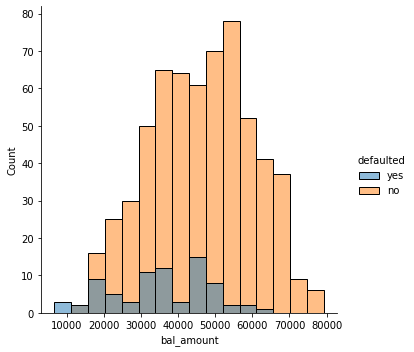

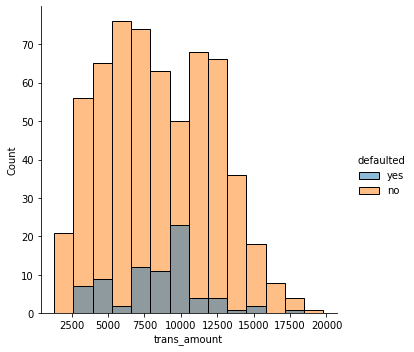

In [15]:
for col in ['number_trans', 'bal_amount', 'trans_amount']:
    sns.displot(data = loan_trans_df, x = col, hue='defaulted')
    graph.show()

So all 3 predictors (average balance amount, average transaction amount, and number transactions) seem useful here

### Loan, account, card, disposition, client

In [16]:
query = """
    select card_t.type as card_type, account_id, gender, birth_date, district_id, disposition_t.type as disp_type
    from loan_t join disposition_t using(account_id)
    left join card_t using(disp_id)
    left join client_t using(client_id);
    """
card_client_df = db.to_df(query)
card_client_df = card_client_df.loc[card_client_df['disp_type'] == 'OWNER']
card_client_df['birth_date'] = pd.to_datetime(card_client_df['birth_date'])

display(card_client_df.head())

,card_type,account_id,gender,birth_date,district_id,disp_type
0,None,2,male,1945-02-04,1,OWNER
2,None,19,female,1939-04-23,21,OWNER
3,None,25,male,1962-02-09,68,OWNER
4,None,37,male,1952-08-26,20,OWNER
5,None,38,female,1940-01-30,19,OWNER


In [17]:
loan_card_client_df = pd.merge(loan_df, card_client_df, on='account_id')
loan_card_client_df = loan_card_client_df[['card_type', 'gender', 'birth_date', 'defaulted']]
display(loan_card_client_df.head())

,card_type,gender,birth_date,defaulted
0,None,female,1947-07-22,yes
1,None,male,1968-07-22,no
2,None,male,1936-06-02,no
3,classic,female,1940-04-20,no
4,junior,male,1978-09-07,no


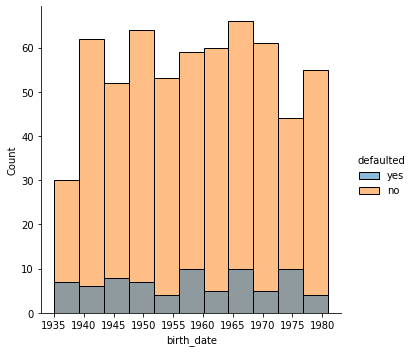

In [18]:
sns.displot(data = loan_card_client_df,  x = 'birth_date', hue='defaulted')
graph.show()

This might be better as age in fact. Let's take a look at that

In [19]:
import datetime
now = datetime.date.today()

loan_card_client_df['age'] = (pd.to_datetime(now) - loan_card_client_df['birth_date']).dt.days // 365
display(loan_card_client_df.head())

,card_type,gender,birth_date,defaulted,age
0,None,female,1947-07-22,yes,74
1,None,male,1968-07-22,no,53
2,None,male,1936-06-02,no,85
3,classic,female,1940-04-20,no,81
4,junior,male,1978-09-07,no,43


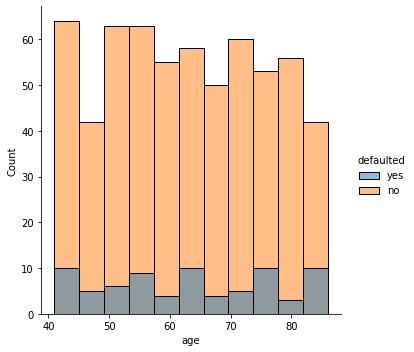

In [20]:
sns.displot(data = loan_card_client_df,  x = 'age', hue='defaulted')
graph.show()

card_type  defaulted
classic    no           130
           yes            3
gold       no            15
           yes            1
junior     no            20
           yes            1
Name: defaulted, dtype: int64


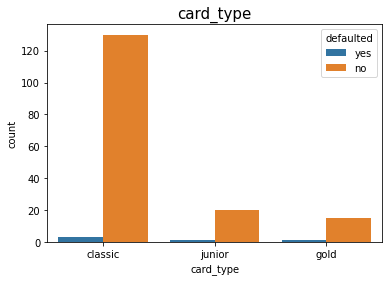

gender  defaulted
female  no           307
        yes           41
male    no           299
        yes           35
Name: defaulted, dtype: int64


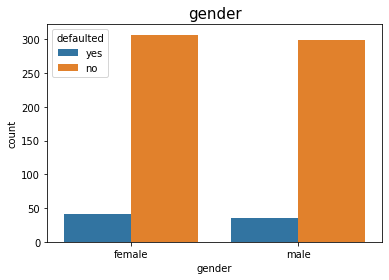

In [21]:
for col in ['card_type', 'gender']:
    print(loan_card_client_df.groupby(col)['defaulted'].value_counts())
    
    graph.title(col, fontsize=15)
    sns.countplot(x = col, data = loan_card_client_df, hue='defaulted')
    graph.show()

There seems to be differences with predictors gender, birthdate/age, and card type. We'll use these too

### Loan, district
This dataframe will need lots of cleaning up

In [22]:
query = """
    select *
    from loan_t join account_t using(account_id)
    join demographic_t using(district_id);
    """
district_df = db.to_df(query)

display(district_df.head())

,district_id,account_id,loan_id,date,amount,duration,payments,status,date,frequency,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,30,1787,5314,1993-07-05,96396,12,8033.00,B,1993-03-22,POPLATEK TYDNE,...,8,2,10,81.8,9650,0.99,0.99,100,2985,2804
1,46,1801,5316,1993-07-11,165960,36,4610.00,A,1993-02-13,POPLATEK MESICNE,...,7,3,10,73.5,8369,0.99,0.99,117,2854,2618
2,45,9188,6863,1993-07-28,127080,60,2118.00,A,1993-02-08,POPLATEK MESICNE,...,6,1,5,53.5,8390,0.99,0.99,132,2080,2122
3,12,1843,5325,1993-08-03,105804,36,2939.00,A,1993-01-30,POPLATEK MESICNE,...,6,1,6,58.0,8754,0.99,0.99,137,3804,3868
4,1,11013,7240,1993-09-06,274740,60,4579.00,A,1993-02-14,POPLATEK TYDNE,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107


In [23]:
# Make average Unemployment
district_df['unemployment_rate'] = district_df[['A12', 'A13']].mean(axis=1)

# Make average crime Rate
district_df['crime_rate'] = district_df[['A15', 'A16']].mean(axis=1) / district_df['A4']


district_df = district_df[['status', 'A3', 'A4', 'A10', 'A11', 'unemployment_rate', 'A14', 'crime_rate']]
district_df.rename(columns = {'A3': 'region', 'A4': 'num_inhabitants', 'A10': 'ratio_urban_inhabitants', 
                              'A11': 'avg_salary', 'A14': 'entrepreneur_rate'}, inplace=True)

district_df['defaulted'] = np.where(district_df['status'].isin(['A', 'C']), 'no', 'yes')
display(district_df)

,status,region,num_inhabitants,ratio_urban_inhabitants,avg_salary,unemployment_rate,entrepreneur_rate,crime_rate,defaulted
0,B,west Bohemia,94812,81.8,9650,0.99,100,0.030529,yes
1,A,east Bohemia,112709,73.5,8369,0.99,117,0.024275,no
2,A,east Bohemia,77917,53.5,8390,0.99,132,0.026965,no
3,A,central Bohemia,107870,58.0,8754,0.99,137,0.035561,no
4,A,Prague,1204953,100.0,12541,0.36,167,0.076677,no
...,...,...,...,...,...,...,...,...,...
677,C,south Bohemia,103347,67.0,9104,0.99,123,0.022512,no
678,C,south Moravia,124605,46.0,8772,0.99,126,0.024124,no
679,C,south Bohemia,51428,52.7,8402,0.99,120,0.020397,no
680,C,north Moravia,161227,69.7,8678,0.99,102,0.029694,no


region           defaulted
Prague           no            77
                 yes            7
central Bohemia  no            80
                 yes           10
east Bohemia     no            75
                 yes            9
north Bohemia    no            60
                 yes            1
north Moravia    no            99
                 yes           18
south Bohemia    no            51
                 yes            9
south Moravia    no           116
                 yes           13
west Bohemia     no            48
                 yes            9
Name: defaulted, dtype: int64


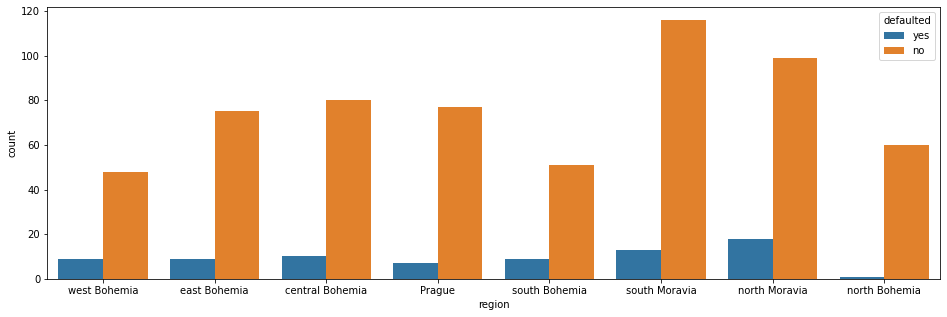

In [24]:
print(district_df.groupby('region')['defaulted'].value_counts())

graph.figure(figsize=(16, 5))
sns.countplot(x = 'region', data = district_df, hue='defaulted')
graph.show()

In [25]:
district_df.columns

Index(['status', 'region', 'num_inhabitants', 'ratio_urban_inhabitants',
       'avg_salary', 'unemployment_rate', 'entrepreneur_rate', 'crime_rate',
       'defaulted'],
      dtype='object')

num_inhabitants


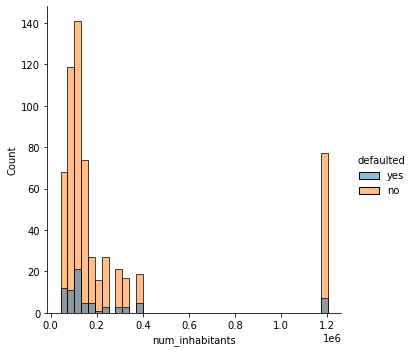

ratio_urban_inhabitants


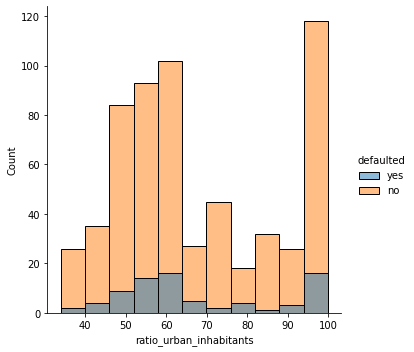

avg_salary


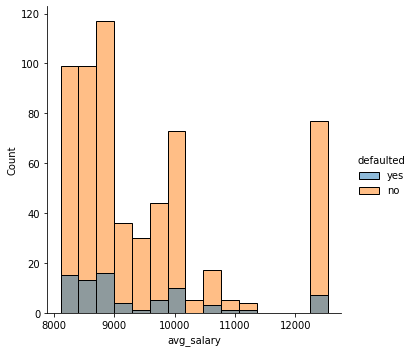

unemployment_rate


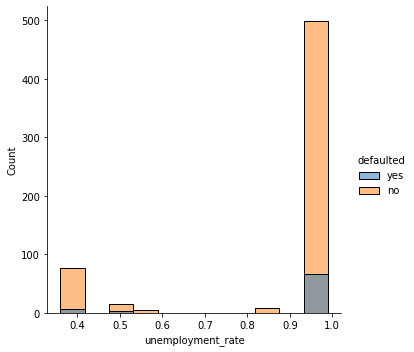

entrepreneur_rate


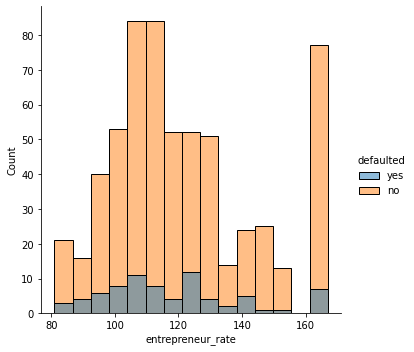

crime_rate


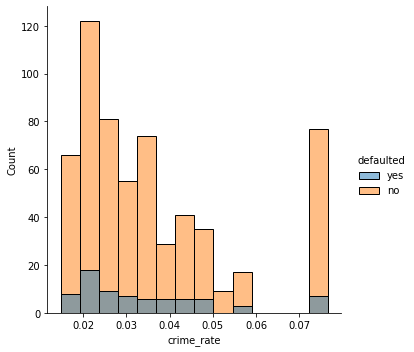

In [26]:
for col in ['num_inhabitants', 'ratio_urban_inhabitants', 'avg_salary', 'unemployment_rate', 'entrepreneur_rate', 'crime_rate']:
    print(col)
    sns.displot(data = district_df, x = col, hue='defaulted')
    graph.show()

This looks good! The district components seem to separate the defaulted loans enough

# Summary

- Target variable is 'status' from loan table
- Predictors are:
    - 'amount', 'duration', 'payments', 'frequency', 'time_elapsed' from loan and account table
    - 'avg_order_amount from order table
    - 'avg_bal_amount', 'avg_trans_amount', and 'num_trans' from transactions table
    - 'age', 'gender' from client table
    - 'card_type' from card table
    - 'region', 'num_inhabitants', 'ratio_urban_inhabitants', 'avg_salary', 'unemployment_rate', 'entrepreneur_rate', 'crime_rate' from district table

We'll do the modeling in the next notebook (WeCloudData_Loan_Default_Modelling)